In [1]:
%matplotlib inline
import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd
from shapely.geometry import Polygon
import numpy as np
import matplotlib.pyplot as plt
import glob

## Quantitative analysis
In order to understand the dynamics of UAOI quantitatively, we selected the area of UAOIs as quantitative indicators, and Middle Layer Super Output Area ([MSOA](https://www.datadictionary.nhs.uk/data_dictionary/nhs_business_definitions/m/middle_layer_super_output_area_de.asp?shownav=1)) as our basic geographic area to store the area of UAOI.

In [4]:
#read all shapefiles
innerlon = gpd.read_file('data/innerlon_nospace.geojson')
msoa = gpd.read_file('data/innerlon_msoa.geojson')
#poly is a repository which can be created by exporting the UAOI info at the end of 'UAOI extraction' file. 
path = r'data/poly'
allFiles = glob.glob(path + "/*.geojson")
aoi_poly = [gpd.read_file(file_).to_crs(msoa.crs) for file_ in allFiles]

Perform spatial intersection munipulation to get UAOI that within MSOA 
* Notice: This spatial analysis process would take hours to get the result. Alternatively, you can do this spatial manipulation in QGIS or ArcMap

In [5]:
msoa_aoi = [gpd.overlay(aoi_poly[i],msoa, how = 'intersection') for i in range(36)]

In [41]:
#have a look at the table after performing spatial intersection
msoa_aoi[0].head()

,area,time,aoi_id,user_num,code,name,label,geometry
0,1.649296,1,1,96,E02000894,Tower Hamlets 031,E09000030E02000894,"POLYGON ((538031.7546912932 178356.0327073209,..."
1,1.649296,1,1,96,E02000893,Tower Hamlets 030,E09000030E02000893,"POLYGON ((538032.486 178348.165, 538031.754691..."
2,1.649296,1,1,96,E02006929,Greenwich 036,E09000011E02006929,"POLYGON ((538758.634 178362.215, 538766.688927..."
3,1.649296,1,1,96,E02006931,Greenwich 038,E09000011E02006931,"POLYGON ((538284.444 178068.064, 538288.27 178..."
4,1.649296,1,1,96,E02006928,Greenwich 035,E09000011E02006928,"POLYGON ((538288.27 178094.74, 538284.444 1780..."


In [40]:
#Calculate the each area of UAOI that within each MSOA 
#A MSOA may contain multiple pieces of different UAOI, sum the total area of UAOI in each MSOA
for i in range(36): 
    msoa_aoi[i]['inter_area']= msoa_aoi[i]['geometry'].area
    msoa_aoi[i]['msoa_area_sum'] = msoa_aoi[i].groupby('name')['inter_area'].transform(sum)

msoa_aoi[0].head()

,area,time,aoi_id,user_num,code,name,label,geometry,inter_area,msoa_area_sum
0,1.649296,1,1,96,E02000894,Tower Hamlets 031,E09000030E02000894,"POLYGON ((538031.7546912932 178356.0327073209,...",47291.157435,47291.157435
1,1.649296,1,1,96,E02000893,Tower Hamlets 030,E09000030E02000893,"POLYGON ((538032.486 178348.165, 538031.754691...",371331.123556,372588.570274
2,1.649296,1,1,96,E02006929,Greenwich 036,E09000011E02006929,"POLYGON ((538758.634 178362.215, 538766.688927...",119717.625636,120240.207030
3,1.649296,1,1,96,E02006931,Greenwich 038,E09000011E02006931,"POLYGON ((538284.444 178068.064, 538288.27 178...",700005.460053,700005.460053
4,1.649296,1,1,96,E02006928,Greenwich 035,E09000011E02006928,"POLYGON ((538288.27 178094.74, 538284.444 1780...",314865.380987,314865.380987


## Spatiotemporal profiles


In [44]:
#create the spatiotemporal profile
profile =[msoa_aoi[i].drop_duplicates('name') for i in range(36)]
#join all profiles with different time into one dataframe
all_join = pd.concat(profile)

In [45]:
all_join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2001 entries, 0 to 81
Data columns (total 10 columns):
area             2001 non-null float64
time             2001 non-null int64
aoi_id           2001 non-null int64
user_num         2001 non-null int64
code             2001 non-null object
name             2001 non-null object
label            2001 non-null object
geometry         2001 non-null object
inter_area       2001 non-null float64
msoa_area_sum    2001 non-null float64
dtypes: float64(3), int64(3), object(4)
memory usage: 172.0+ KB


In [46]:
#Since sort out the all_join table to keep only three useful columns: 
#name of MSOA, time and msoa_area_sum
aoi_msoa_area = pd.pivot_table(all_join, values='msoa_area_sum', index=['name'],
                  columns=['time'], aggfunc=np.sum)

aoi_msoa_area.head()

time,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
name,,,,,,,,,,,,,,,,,,,,,
Camden 001,898083.534282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Camden 002,692592.837005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Camden 006,4341.599509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021.608494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Camden 007,NaN,NaN,NaN,NaN,22856.423916,NaN,26937.777041,53711.469619,39728.519357,NaN,...,108194.003704,NaN,2698.045566,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Camden 009,NaN,NaN,NaN,9058.739379,32620.082982,435.734493,14389.312724,31079.996671,20483.222869,8316.037192,...,18047.664531,NaN,17040.201624,16405.369737,34.58956,NaN,7589.082086,2918.623767,NaN,705.217001


In [23]:
#Calculate the sum area of MSOA
msoa['msoa_area'] = msoa.geometry.area
#merge MSOA layer with sum area of UAOI within MSOA layer  
merge = pd.merge(msoa, aoi_msoa_area, how = 'outer', left_on = 'name',right_on = aoi_msoa_area.index)
merge.index= merge.name
merge.drop(merge.columns[[0,1,2,3]], axis=1, inplace=True)

In [38]:
merge.head()

,msoa_area,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
name,,,,,,,,,,,,,,,,,,,,,
City of London 001,3.151466e+06,665881.364172,5763.270771,454425.073914,132678.680146,277262.150236,620927.109451,286606.101893,109692.880785,869244.040336,...,3.151466e+06,447675.473384,271803.190094,509653.826476,632243.867712,621534.748704,569977.004898,481088.123772,646402.268151,807825.536398
Camden 001,3.024019e+06,898083.534282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Camden 002,2.080874e+06,692592.837005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Camden 003,6.805386e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Camden 004,1.122201e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
#standarise the area by MSOA
aoi_msoa_area_stand = merge.div(merge.msoa_area, axis='index')
aoi_msoa_area_stand = aoi_msoa_area_stand.drop('msoa_area',axis = 1).T
aoi_msoa_area_stand.head()

name,City of London 001,Camden 001,Camden 002,Camden 003,Camden 004,Camden 005,Camden 006,Camden 007,Camden 008,Camden 009,...,Southwark 034,Tower Hamlets 032,Tower Hamlets 033,Hackney 028,Hackney 029,Greenwich 034,Greenwich 035,Greenwich 036,Greenwich 037,Greenwich 038
1,0.211293,0.296983,0.332837,NaN,NaN,NaN,0.008325,NaN,NaN,NaN,...,NaN,0.358048,0.929657,NaN,NaN,NaN,0.420736,0.033264,0.083984,0.341602
2,0.001829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.336837,0.834719,NaN,NaN,NaN,0.359756,0.043658,0.103474,0.263508
3,0.144195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.269193,0.940132,NaN,NaN,NaN,0.406094,0.011993,0.063174,0.318785
4,0.042101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016596,...,NaN,0.292432,0.966119,NaN,NaN,NaN,0.546808,0.050524,0.098713,0.464911
5,0.087979,NaN,NaN,NaN,NaN,NaN,NaN,0.034168,NaN,0.059762,...,NaN,0.124534,0.829478,NaN,NaN,NaN,0.657015,0.118300,0.125400,0.430865


In [36]:
#select three typical MSOA that showing seasonal pattern apprarently
msoa_3 = aoi_msoa_area_stand[[ 'Westminster 020', 'Tower Hamlets 030','Newham 034']]
msoa_3.head()

name,Westminster 020,Tower Hamlets 030,Newham 034
1,0.154143,0.349547,NaN
2,0.568647,0.254735,NaN
3,0.236088,0.214384,NaN
4,0.122915,0.269482,NaN
5,0.218458,0.334799,0.232677


## Visualisation

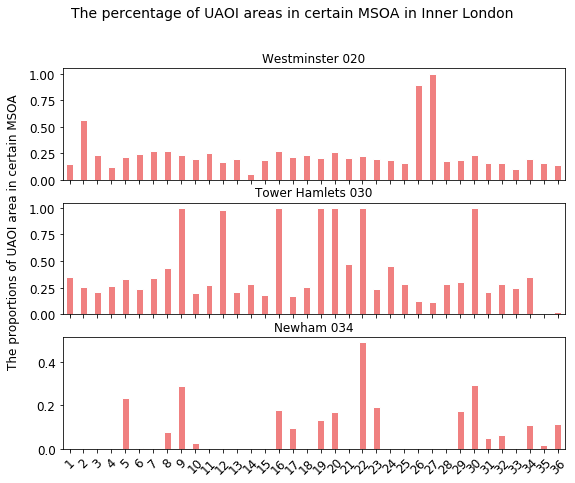

In [35]:
bar_plot = msoa_3.plot.bar(color='lightcoral',subplots = True, figsize = (9,7), legend = False,
                       edgecolor='white', fontsize = 12)
plt.text(16,2,'The percentage of UAOI areas in certain MSOA in Inner London', horizontalalignment='center',
         verticalalignment='center',fontsize = 14)
#stick the same location for legend
#for i, ax in enumerate(bar_plot):
#    bar_plot[i].legend(loc = 2)
#add x and y labels
#plt.text(16, 0.5, 'Time intervals from 2013-01 to 2015-12', ha='center', va='center', fontsize = 12)
plt.text(-4, 1, 'The proportions of UAOI area in certain MSOA', 
        ha='center', va='center', rotation='vertical', fontsize = 12)
plt.xticks(rotation=45)
plt.show()